# Redes de deslocamento para acesso ao parto hospitalar no Brasil

https://pcdas.icict.fiocruz.br/rede-de-parcerias/a-distancia-importa-redes-de-deslocamento-para-acesso-ao-parto-hospitalar-no-brasil/

## Importação de Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
from gdown import download
from os.path import isfile
from zipfile import ZipFile
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from pandas_profiling import ProfileReport

## Acesso aos Dados

In [3]:
URL = 'https://drive.google.com/uc?id=149l5K6rEXWZ6MhIfSsatSN_Q5Esum7x1'
DATASET_OUTPUT = 'data/SIHSUS.zip'

In [4]:
if isfile(DATASET_OUTPUT):
    zf = ZipFile(DATASET_OUTPUT)
else:
    download(URL, DATASET_OUTPUT, quiet=False)

## Dicionário de Variáveis

https://pcdas.icict.fiocruz.br/conjunto-de-dados/sistema-de-informacoes-hospitalares-do-sus-sihsus/dicionario-de-variaveis/

In [5]:
COLUMNS = [
  'ANO_CMPT',
  'MUNIC_RES',
  'NASC',
  'PROC_REA', # ['0310010039', '0411010034']
  'DT_INTER',
  'MUNIC_MOV',
  'IDADE',
  'INSTRU',
  'CNES',
  'RACA_COR',
  'CGC_HOSP',
  'ano_internacao',
  'int_MSAUDCOD', 'int_RSAUDCOD', 'int_LATITUDE', 'int_LONGITUDE', 'int_REGIAO', 'int_SIGLA_UF', 'int_NOME_UF', 'int_MUNNOMEX',
  'res_SIGLA_UF', 'res_MUNNOMEX', 'res_MSAUDCOD', 'res_RSAUDCOD', 'res_LATITUDE', 'res_LONGITUDE', 'res_REGIAO',
  'def_idade_anos', 'def_procedimento_realizado', 'def_rsaud_res', 'def_rsaud_int',
  # missing values:
  'res_uf_CODIGO_UF', 'res_MUNCOD',
  'def_regiao_int', 'def_regiao_res', 'def_uf_int', 'def_uf_sigla_int', 'def_uf_res', 'def_uf_sigla_res', 'def_municipio_int', 'def_municipio_res',
  'cod_uf_res', 'cod_uf_mov',
  'idade_nascimento_anos',
]

PROC_REA_PARTOS = [
  '0310010039',
  '0411010034',
]

DICT_OUTPUT = 'data/info/dict_cols.csv'

In [6]:
if isfile(DICT_OUTPUT):
    dict_cols = pd.read_csv(DICT_OUTPUT)
else:
    dict_sih = pd.read_csv(zf.open('dict_SIH.csv'), sep = ';')
    dict_sih['Tipo'] = dict_sih['Tipo'].map({
        'text' : 'object',
        'int8' : 'int64',
        'float8' : 'float32',
        'date' : 'object', # columns = {dt_inter, dt_saida}
    })
    dict_cols = dict_sih[dict_sih['Coluna'].isin(COLUMNS)]
    dict_cols.to_csv(DICT_OUTPUT, index=False)
dict_cols

,Coluna,Tipo,Descrição
0,ANO_CMPT,int64,Ano de processamento da AIH
1,CGC_HOSP,object,CNPJ do estabelecimento
2,MUNIC_RES,int64,Município de residência do paciente
3,cod_uf_res,int64,Código da UF de residência do paciente
4,NASC,int64,Data de nascimento do paciente
5,PROC_REA,object,Procedimento realizado
6,DT_INTER,int64,Data de internação
7,MUNIC_MOV,int64,Município do estabelecimento
8,cod_uf_mov,int64,Código da UF do estabelecimento
9,IDADE,int64,Idade


## Tabelas Existentes

In [7]:
def get_row_from(fname):
  f = fname.split('.')[1].split('_')
  return {
    'File Name' : fname,
    'State' : f[1],
    'Year' : int(f[2]),
    'Month' : int(f[3]),
  }

In [8]:
FNAME_COLS = ['File Name', 'State', 'Year', 'Month', 'Rows']

In [9]:
tabelas = pd.DataFrame([
  get_row_from(fname)
    for fname in zf.namelist() if (
      fname[0] == 'E')
]).sort_values(
  by = FNAME_COLS[1:-1],
  ignore_index = True)
tabelas

,File Name,State,Year,Month
0,ETLSIH.ST_AC_2008_1_t.csv,AC,2008,1
1,ETLSIH.ST_AC_2008_2_t.csv,AC,2008,2
2,ETLSIH.ST_AC_2008_3_t.csv,AC,2008,3
3,ETLSIH.ST_AC_2008_4_t.csv,AC,2008,4
4,ETLSIH.ST_AC_2008_5_t.csv,AC,2008,5
...,...,...,...,...
4395,ETLSIH.ST_TO_2021_3_t.csv,TO,2021,3
4396,ETLSIH.ST_TO_2021_4_t.csv,TO,2021,4
4397,ETLSIH.ST_TO_2021_5_t.csv,TO,2021,5
4398,ETLSIH.ST_TO_2021_6_t.csv,TO,2021,6


### Estados por ano que não possui os 12 meses completos

In [10]:
estados_ano = tabelas.groupby(['State', 'Year'], as_index=False).count()
estados_ano = estados_ano[estados_ano['Month'] != 12]
estados_ano = estados_ano[['State', 'Year', 'Month']].rename(columns={'Month': 'Months'})
estados_ano = estados_ano.pivot(*['Year', 'State', 'Months'])
estados_ano

State,AC,AL,AM,AP,BA,CE,DF,ES,GO,MA,...,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
Year,,,,,,,,,,,,,,,,,,,,,
2009,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0


### Tabelas entre 2010 e 2020

- 27 Unidades Federativas;
- 11 Anos de cobertura;
- 12 Meses cada ano;
- 27 x 11 x 12 = 3564 tabelas.

In [11]:
tabelas = tabelas[(tabelas['Year'] >= 2010) & (tabelas['Year'] <= 2020)]
tabelas

,File Name,State,Year,Month
23,ETLSIH.ST_AC_2010_1_t.csv,AC,2010,1
24,ETLSIH.ST_AC_2010_2_t.csv,AC,2010,2
25,ETLSIH.ST_AC_2010_3_t.csv,AC,2010,3
26,ETLSIH.ST_AC_2010_4_t.csv,AC,2010,4
27,ETLSIH.ST_AC_2010_5_t.csv,AC,2010,5
...,...,...,...,...
4388,ETLSIH.ST_TO_2020_8_t.csv,TO,2020,8
4389,ETLSIH.ST_TO_2020_9_t.csv,TO,2020,9
4390,ETLSIH.ST_TO_2020_10_t.csv,TO,2020,10
4391,ETLSIH.ST_TO_2020_11_t.csv,TO,2020,11


## Completude das Tabelas

In [12]:
def get_columns(fname):
    dataset = zf.open(fname)
    cols = dataset.readline()
    cols = cols.decode('utf-8')[:-1]
    cols = cols.split(',')
    return set(cols)

def open_table(fname):
    set_cols = set(COLUMNS)
    cols = get_columns(fname)
    intersec_cols = set_cols.intersection(cols)
    missing_cols = set_cols - intersec_cols
    df = pd.read_csv(
            zf.open(fname),
            usecols = intersec_cols,
            dtype = {row['Coluna'] : row['Tipo']
                for _, row in dict_cols[
                    dict_cols['Coluna'].isin(cols)
                ].iterrows()})
    df = df[df['PROC_REA'].isin(PROC_REA_PARTOS)]
    for col in missing_cols:
        df[col] = np.nan
    return df[COLUMNS]

def get_completeness(table_info):
    df = open_table(table_info['File Name'])
    info = {
        'File Name' : table_info['File Name'],
        'State' : table_info['State'],
        'Year' : table_info['Year'],
        'Month' : table_info['Month'],
        'Rows' : df.shape[0],
    }
    for col, val in df.notna().sum().iteritems():
        info[col] = val
    return info

### Linhas não Nulas

In [13]:
NOTNULL_OUTPUT = 'data/info/notnull.csv'

In [14]:
if isfile(NOTNULL_OUTPUT):
    notnulls = pd.read_csv(NOTNULL_OUTPUT)
else:
  notnulls = pd.DataFrame([
    get_completeness(table_info)
      for _, table_info in tqdm(tabelas.iterrows(), total=len(tabelas))
  ]).sort_values(
    by = FNAME_COLS[1:-1],
    ignore_index = True)
  notnulls = notnulls[FNAME_COLS+COLUMNS]
  notnulls.to_csv(NOTNULL_OUTPUT, index=False)
notnulls

,File Name,State,Year,Month,Rows,ANO_CMPT,MUNIC_RES,NASC,PROC_REA,DT_INTER,...,def_regiao_res,def_uf_int,def_uf_sigla_int,def_uf_res,def_uf_sigla_res,def_municipio_int,def_municipio_res,cod_uf_res,cod_uf_mov,idade_nascimento_anos
0,ETLSIH.ST_AC_2010_1_t.csv,AC,2010,1,935,935,935,935,935,935,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ETLSIH.ST_AC_2010_2_t.csv,AC,2010,2,810,810,810,810,810,810,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ETLSIH.ST_AC_2010_3_t.csv,AC,2010,3,819,819,819,819,819,819,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ETLSIH.ST_AC_2010_4_t.csv,AC,2010,4,989,989,989,989,989,989,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ETLSIH.ST_AC_2010_5_t.csv,AC,2010,5,1152,1152,1152,1152,1152,1152,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3559,ETLSIH.ST_TO_2020_8_t.csv,TO,2020,8,1591,1591,1591,1591,1591,1591,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3560,ETLSIH.ST_TO_2020_9_t.csv,TO,2020,9,1473,1473,1473,1473,1473,1473,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3561,ETLSIH.ST_TO_2020_10_t.csv,TO,2020,10,1333,1333,1333,1333,1333,1333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3562,ETLSIH.ST_TO_2020_11_t.csv,TO,2020,11,1248,1248,1248,1248,1248,1248,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Completude por Coluna

In [15]:
dict_cols['Completude'] = dict_cols['Coluna'].apply(
    lambda col : round(
        notnulls[col].sum() / notnulls['Rows'].sum() * 100,
        2))
dict_cols

,Coluna,Tipo,Descrição,Completude
0,ANO_CMPT,int64,Ano de processamento da AIH,100.00
1,CGC_HOSP,object,CNPJ do estabelecimento,70.42
2,MUNIC_RES,int64,Município de residência do paciente,100.00
3,cod_uf_res,int64,Código da UF de residência do paciente,0.00
4,NASC,int64,Data de nascimento do paciente,100.00
5,PROC_REA,object,Procedimento realizado,100.00
6,DT_INTER,int64,Data de internação,100.00
7,MUNIC_MOV,int64,Município do estabelecimento,100.00
8,cod_uf_mov,int64,Código da UF do estabelecimento,0.00
9,IDADE,int64,Idade,100.00


In [16]:
uncomplt_cols = dict_cols[
    (dict_cols['Completude'] != 100) & (dict_cols['Completude'] != 0)]
uncomplt_cols = uncomplt_cols.sort_values(by=['Completude'])
uncomplt_cols

,Coluna,Tipo,Descrição,Completude
1,CGC_HOSP,object,CNPJ do estabelecimento,70.42
33,def_rsaud_int,object,Região de saúde do estabelecimento de internação,90.36
34,def_rsaud_res,object,Região de saúde de residência do paciente,98.83
17,res_LATITUDE,float32,Longitude da sede do Município de residência d...,99.99
18,res_LONGITUDE,float32,"Altitude, em metros, da sede do Município de r...",99.99


### Completude por Ano x Estado

In [17]:
def completness_by_year_state(column):
    col_order = ['Year', 'State', 'Percent']
    df = notnulls[col_order[:2]].copy()
    df['Percent'] = round(notnulls[column] / notnulls['Rows'] * 100,2)
    df = df[col_order].groupby(
        by = col_order[:2],
        as_index = False).mean()
    df['Year'] = [int(str(year)[-2:])
        for year in df['Year']]
    df = df.pivot(*col_order)
    df = df.sort_values(
        by = 'Year',
        ascending = False)
    return df

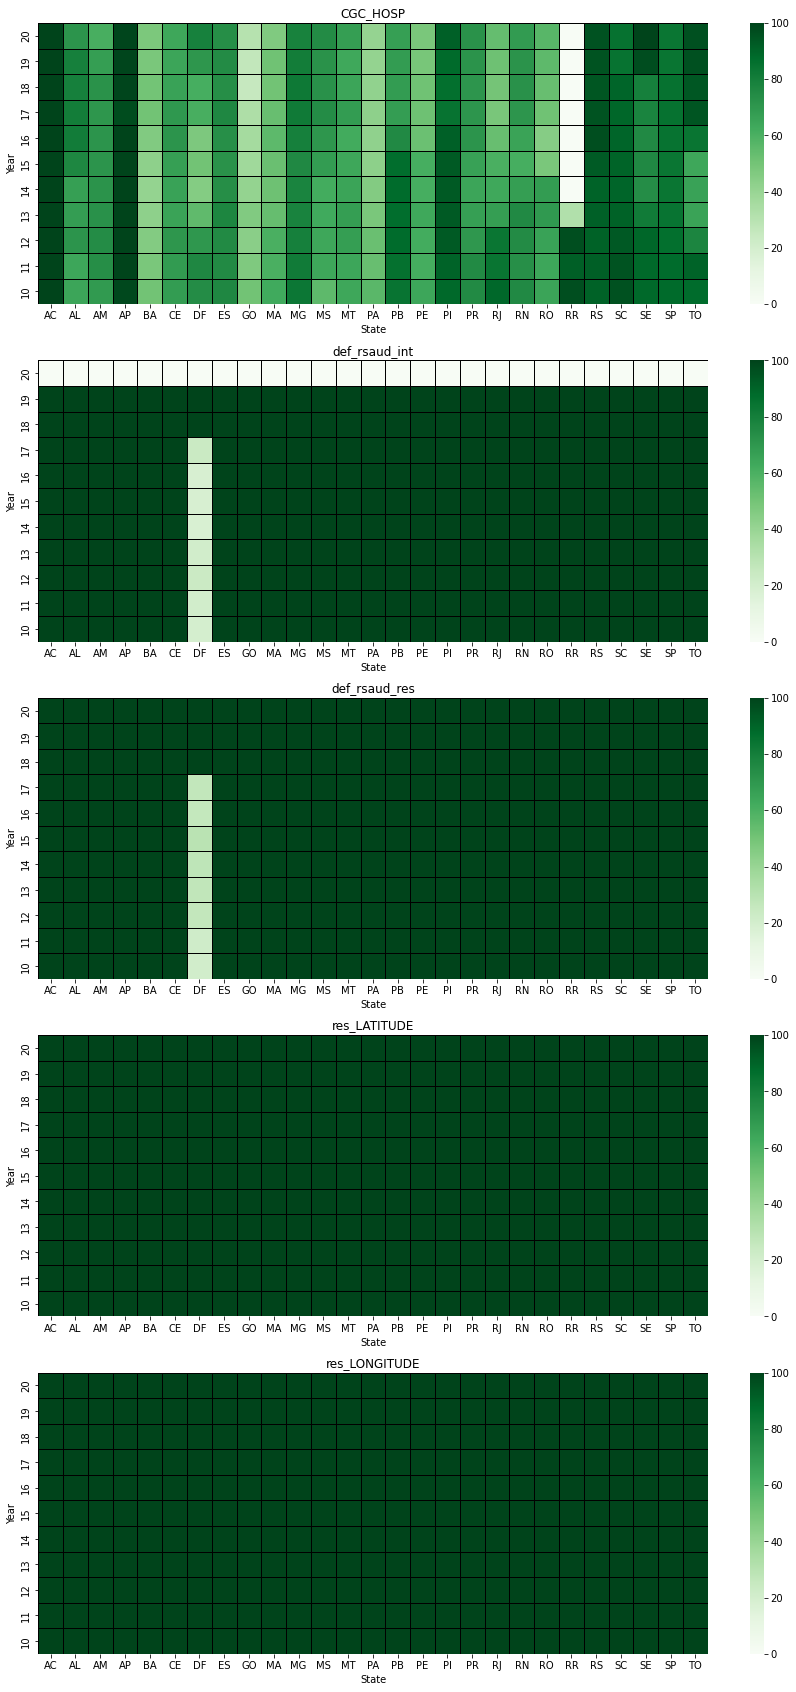

In [18]:
f, axes = plt.subplots(5, 1, figsize=(15, 30))#, sharex=True)
for i, col in enumerate(uncomplt_cols['Coluna']):
    sns.heatmap(
        data = completness_by_year_state(col),
        cmap = 'Greens',
        linewidths = .5,
        linecolor = 'black',
        vmin = 0,
        vmax = 100,
        ax = axes[i],
    )
    axes[i].set_title(col)

### Incompletude

In [19]:
UNCOMPLETE_OUTPUT = 'data/info/uncomplete.csv'

In [20]:
if isfile(UNCOMPLETE_OUTPUT):
    uncomplt = pd.read_csv(UNCOMPLETE_OUTPUT)
else:
    missing_values = []
    for i, row in notnulls.iterrows():
        for col in COLUMNS:
            if row[col] != row['Rows']:
                diff = row['Rows'] - row[col]
                missing_values.append({
                    'File Name' : row['File Name'],
                    'State' : row['State'],
                    'Year' : row['Year'],
                    'Month' : row['Month'],
                    'Column' : col,
                    'Rows' : row['Rows'],
                    'Missing' : diff,
                    'Percent' : round(diff / row['Rows'] * 100, 2),
                })
    uncomplt = pd.DataFrame(missing_values)
    uncomplt.sort_values(
        by=['Percent']+FNAME_COLS[1:-1],
        ascending=False,
        ignore_index=True,
        inplace=True)
    # uncomplt.to_csv(UNCOMPLETE_OUTPUT, index=False)
uncomplt

,File Name,State,Year,Month,Column,Rows,Missing,Percent
0,ETLSIH.ST_TO_2020_12_t.csv,TO,2020,12,def_rsaud_int,1162,1162.0,100.0
1,ETLSIH.ST_TO_2020_11_t.csv,TO,2020,11,def_rsaud_int,1248,1248.0,100.0
2,ETLSIH.ST_TO_2020_10_t.csv,TO,2020,10,def_rsaud_int,1333,1333.0,100.0
3,ETLSIH.ST_TO_2020_9_t.csv,TO,2020,9,def_rsaud_int,1473,1473.0,100.0
4,ETLSIH.ST_TO_2020_8_t.csv,TO,2020,8,def_rsaud_int,1591,1591.0,100.0
...,...,...,...,...,...,...,...,...
50885,ETLSIH.ST_AC_2010_1_t.csv,AC,2010,1,def_municipio_int,935,NaN,NaN
50886,ETLSIH.ST_AC_2010_1_t.csv,AC,2010,1,def_municipio_res,935,NaN,NaN
50887,ETLSIH.ST_AC_2010_1_t.csv,AC,2010,1,cod_uf_res,935,NaN,NaN
50888,ETLSIH.ST_AC_2010_1_t.csv,AC,2010,1,cod_uf_mov,935,NaN,NaN


<AxesSubplot:>

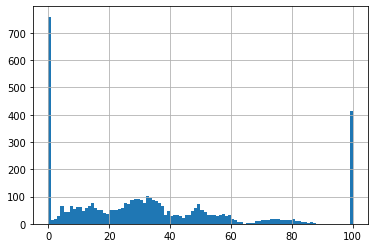

In [21]:
uncomplt['Percent'].hist(bins=100)